Data: Source is Question-Answer pair and target is a set of Distractor(Varries from 1 to 3). 
Approch: 
* I will make an Encoder-Decoder model for this task. 
* I will only consider the question as source and either of the answer or 1st distractor as target. Here I am assuming that if I treat this as a simple question answering model it's going to give us answers which are very close to the real ans but not the actual so we can use it as a distractor. (This assumption is not always true especially when I am using the actual answer to train the model. It when it involves any token word or number in the question which is the real answer. So I will use the distractor 1 to train) 
* For embedding I will use glove.6B.100d


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/mcq-distractors/Test.csv
/kaggle/input/mcq-distractors/Train.csv
/kaggle/input/glove6b100dtxt/glove.6B.100d.txt


In [2]:
import numpy as np
import pandas as pd
import re
import keras.backend as K
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, SimpleRNN, LSTM, GRU, Dropout, Dense, Activation
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [3]:
data = pd.read_csv('/kaggle/input/mcq-distractors/Train.csv')

# only taking sentences of length <= 25
data['question_len'] = data['question'].apply(lambda x: len(x.split()))
data['distractor_len'] = data['distractor'].apply(lambda x: len(x.split()))

data = data[data['question_len']<=25]
data = data[data['distractor_len']<=25]

In [4]:
# remove quotes
data['question'] = data['question'].apply(lambda x: re.sub("'", '', x))
data['distractor'] = data['distractor'].apply(lambda x: re.sub("'", '', x))

In [5]:
source = data.loc[:,'question']
target = data.loc[:,'distractor']

# Adding START_ and _END tokens
target = target.apply(lambda x:'START_ '+x+' _END')
type(target)

pandas.core.series.Series

In [6]:
#tokenizing the source words
t_source = Tokenizer()
t_source.fit_on_texts(source)
source_vocab_size = len(t_source.word_index)+1
   
#tokenizing the target words
t_target = Tokenizer()
t_target.fit_on_texts(target)
target_vocab_size = len(t_target.word_index)+1

In [7]:
# tokenizing the source and target 
source = t_source.texts_to_sequences(source)
target = t_target.texts_to_sequences(target)


In [8]:
source_train, source_test, target_train, target_test = train_test_split(source, target, test_size=0.2, random_state = 21)


In [9]:
# generating batch for training
def generate_batch(X, y, batch_size=64):
    while True:
        for b in range(0, len(X), batch_size):
            encoder_source = np.zeros([batch_size, 25], dtype='float32')
            decoder_source = np.zeros([batch_size, 26], dtype='float32')
            decoder_target = np.zeros([batch_size, 26, target_vocab_size])
            for i, (source_sen, target_sen) in enumerate(zip(X[b:b+batch_size],y[b:b+batch_size])):
                for j, k in enumerate(source_sen):
                    encoder_source[i, j] = k
                for j, k in enumerate(target_sen):
                    if j<len(target_sen):
                        decoder_source[i, j] = k
                    if j>0:
                        decoder_target[i, j-1, k] = 1
                    
                        
            yield ([encoder_source, decoder_source], decoder_target)
            
            
            

In [10]:
# embedding matrix
embedding_index = dict()
f = open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt', encoding="utf8")
for line in f:
   values = line.split()
   word = values[0]
   coefs = np.asarray(values[1:])
   embedding_index[word] = coefs
f.close()
    
embedding_matrix_source = np.zeros([source_vocab_size, 100])
for word, i in t_source.word_index.items():
   embedding_vector = embedding_index.get(word)
   if embedding_vector is not None:
      embedding_matrix_source[i] = embedding_vector
            
embedding_matrix_target = np.zeros([target_vocab_size, 100])
for word, i in t_target.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_target[i] = embedding_vector

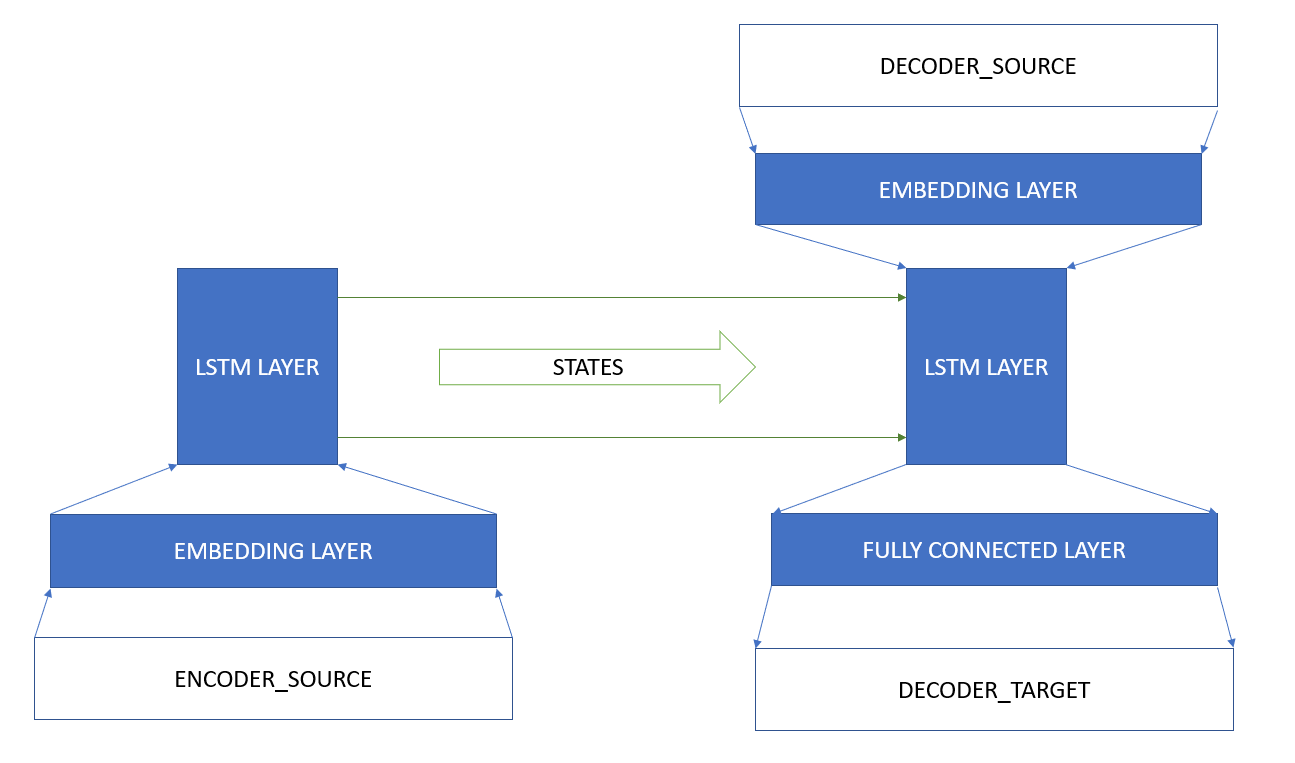

In [11]:
latent_dim = 100
# encoder
encoder_input = Input(shape=(None,))
encoder_embedding = Embedding(source_vocab_size, latent_dim, weights=[embedding_matrix_source], mask_zero=True)
encoder_embedded = encoder_embedding(encoder_input)
encoder_LSTM = LSTM(latent_dim, return_state = True)
source_encoder_outputs, source_state_h, source_state_c = encoder_LSTM(encoder_embedded)
encoder_state = [source_state_h, source_state_c]

# decoder
decoder_input = Input(shape=(None,))
decoder_embedding = Embedding(target_vocab_size, latent_dim, weights=[embedding_matrix_target], mask_zero=True)
decoder_embedded = decoder_embedding(decoder_input)
decoder_LSTM = LSTM(latent_dim, return_state = True, return_sequences=True)
decoder_outputs, _, _ = decoder_LSTM(decoder_embedded, initial_state = encoder_state)
decoder_dense = Dense(target_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


In [12]:
model = Model([encoder_input, decoder_input], decoder_outputs)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

print(model.summary())


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    1289000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 100)    1346900     input_2[0][0]                    
____________________________________________________________________________________________

In [13]:
model.fit_generator(generator=generate_batch(source_train, target_train, batch_size=64),steps_per_epoch = len(source_train)//64, validation_data=generate_batch(source_test, target_test, batch_size=64), validation_steps=len(source_test)//64, epochs = 25)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/25
392/392 [==============================] - 103s 263ms/step - loss: 2.0121 - accuracy: 0.1346 - val_loss: 2.0004 - val_accuracy: 0.1589
Epoch 2/25
392/392 [==============================] - 101s 258ms/step - loss: 1.8216 - accuracy: 0.1750 - val_loss: 1.7043 - val_accuracy: 0.1864
Epoch 3/25
392/392 [==============================] - 102s 260ms/step - loss: 1.7236 - accuracy: 0.1976 - val_loss: 1.7399 - val_accuracy: 0.1986
Epoch 4/25
392/392 [==============================] - 102s 260ms/step - loss: 1.6635 - accuracy: 0.2076 - val_loss: 1.8427 - val_accuracy: 0.2047
Epoch 5/25
392/392 [==============================] - 102s 259ms/step - loss: 1.6199 - accuracy: 0.2149 - val_loss: 1.7958 - val_accuracy: 0.2074
Epoch 6/25
392/392 [==============================] - 102s 260ms/step - loss: 1.5869 - accuracy: 0.2208 - val_loss: 1.5609 - val_accuracy: 0.2124
Epoch 7/25
392/392 [==============================] - 102s 261ms/step - loss: 1.5574 - accuracy: 0.2260 - val_loss: 1.5767 -